<a href="https://colab.research.google.com/github/msskx/deepLearning/blob/main/VGG%E9%A2%84%E8%AE%AD%E7%BB%83%E6%A8%A1%E5%9E%8B%E8%AF%86%E5%88%AB%E5%A4%A9%E6%B0%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/torch学习笔记/weather_classification.zip

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import os
import shutil

In [5]:
base_dir = r'/content/weather_classification'


In [6]:
train_dir = os.path.join(base_dir , 'train')
test_dir = os.path.join(base_dir , 'test')  

In [7]:

from torchvision import transforms

In [8]:
transform = transforms.Compose([
                  transforms.Resize((96, 96)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                       std=[0.5, 0.5, 0.5])
])


In [12]:

train_ds = torchvision.datasets.ImageFolder(
               train_dir,
               transform=transform
)


In [13]:

test_ds = torchvision.datasets.ImageFolder(
               test_dir,
               transform=transform
)


In [14]:
BATCHSIZE = 16


In [15]:
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BATCHSIZE,
                                       shuffle=True
)


In [27]:

test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BATCHSIZE,
)

In [17]:

imgs, labels = next(iter(train_dl))


In [18]:

id_to_class = dict((v, k) for k, v in train_ds.class_to_idx.items())



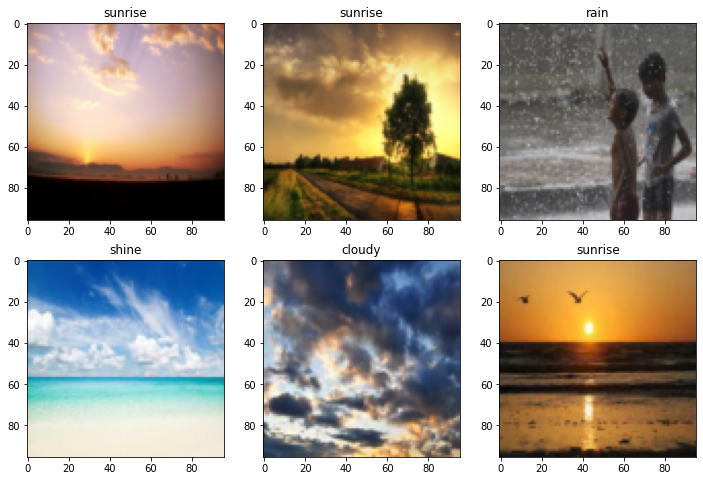

In [19]:

plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.title(id_to_class.get(label.item()))
    plt.imshow(img)

In [20]:
model=torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
#冻结特征提取层

In [22]:
for param in model.features.parameters():
  param.requires_grad=False

In [23]:
model.classifier[-1].out_features=4

In [24]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [25]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=20, device='cuda'):
   
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()
    model.to(device)
    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
              (epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP
    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    plt.figure(dpi=150)
    plt.plot(range(1,epochs+1),history['loss'],label='train_loss')
    plt.plot(range(1,epochs+1),history['val_loss'],label='test_loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.figure(dpi=150)
    plt.plot(range(1,epochs+1),history['acc'],label='train_acc')
    plt.plot(range(1,epochs+1),history['val_acc'],label='test_acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()
    return history

train() called: model=VGG, opt=Adam(lr=0.001000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  1.77, train acc:  0.80, val loss:  3.95, val acc:  0.83
Epoch   2/ 20, train loss:  1.32, train acc:  0.91, val loss:  1.16, val acc:  0.93
Epoch   3/ 20, train loss:  0.79, train acc:  0.95, val loss:  3.22, val acc:  0.85
Epoch   4/ 20, train loss:  2.21, train acc:  0.94, val loss:  2.44, val acc:  0.94
Epoch   5/ 20, train loss:  1.11, train acc:  0.96, val loss:  2.52, val acc:  0.92
Epoch   6/ 20, train loss:  0.91, train acc:  0.96, val loss:  4.57, val acc:  0.91
Epoch   7/ 20, train loss:  2.12, train acc:  0.96, val loss:  1.99, val acc:  0.96
Epoch   8/ 20, train loss:  0.89, train acc:  0.97, val loss:  3.78, val acc:  0.95
Epoch   9/ 20, train loss:  1.19, train acc:  0.97, val loss:  6.77, val acc:  0.92
Epoch  10/ 20, train loss:  1.69, train acc:  0.97, val loss:  6.10, val acc:  0.93
Epoch  11/ 20, train loss:  0.67, train acc:  0.98, val loss:  7.40, val acc:  0.92
Ep

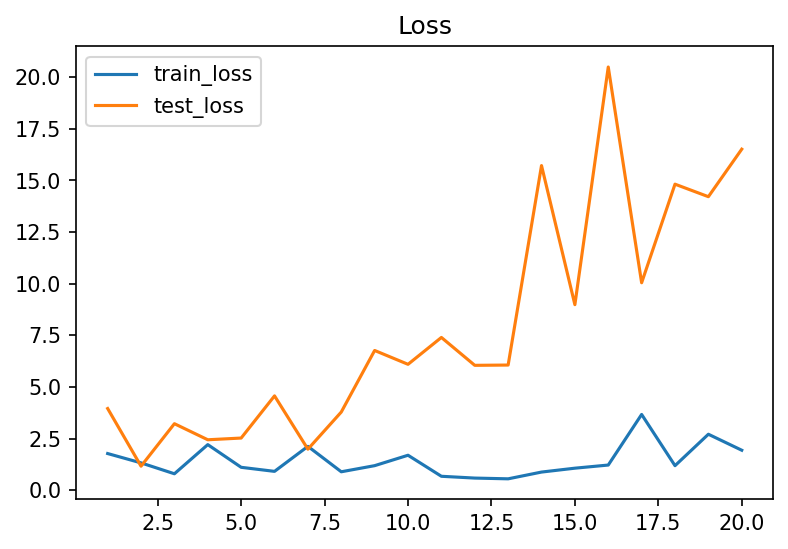

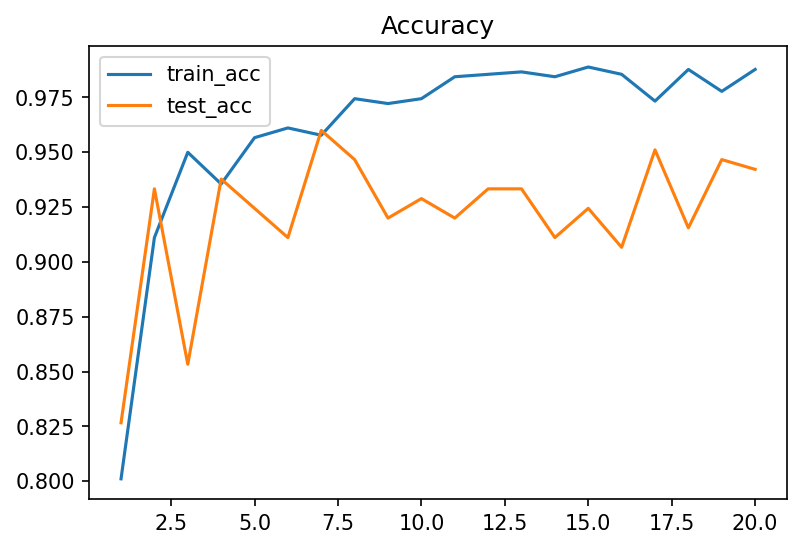

In [28]:
history=train(model, optim, loss_fn, train_dl, test_dl, epochs=20, device='cuda')
